# Yelp Dataset

Follow the instructions on the [download-site](https://www.yelp.com/dataset/download) and make sure the `yelp_academic_dataset_review.json` file is located under `datasets/yelp/`

In [5]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

DATASET_LOCATION = "../datasets/yelp_full/yelp_academic_dataset_review.json"

### Validity check

In [6]:
VERIFY_CHECKSUM = False
CHECKSUM = '24bbad7486bc4922501457414e082686'

In [7]:
assert os.path.exists(DATASET_LOCATION)

if VERIFY_CHECKSUM:
    with open(DATASET_LOCATION, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert CHECKSUM == file_hash.hexdigest()
    print("Checksum matches")


### Read data

##### For the analysis only `text` and `stars` will be used

In [8]:
pd.read_json(DATASET_LOCATION, lines=True, nrows=5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [9]:
chunks = []
chunksize = 1000
total_iterations = 8021122/chunksize
with pd.read_json(DATASET_LOCATION, lines=True, chunksize=chunksize) as reader:
    for chunk in tqdm(reader, total=total_iterations):
        chunks.append(chunk[['text', 'stars']])

8022it [03:49, 35.02it/s]                                                                                              


In [10]:
df_yelp = pd.concat(chunks)
df_yelp.shape

(8021122, 2)

In [11]:
df_yelp.head()

,text,stars
0,"As someone who has worked with many museums, I...",2
1,I am actually horrified this place is still in...,1
2,I love Deagan's. I do. I really do. The atmosp...,5
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
4,"Oh happy day, finally have a Canes near my cas...",4


Text(0.5, 0, 'Count')

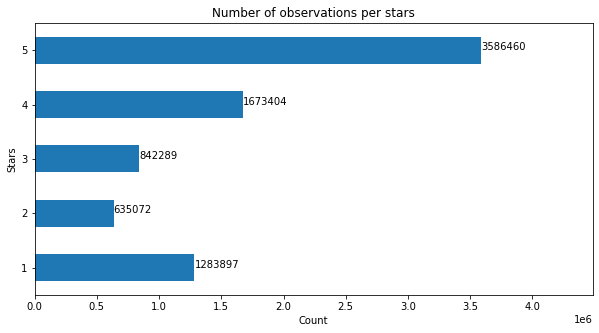

In [12]:
vc = df_yelp.stars.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per stars', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Stars')
ax.set_xlabel('Count')

### Export

In [13]:
PREPROCESSED_FILE = '../datasets/preprocessed/yelp_full.csv'
df_yelp.columns = ['text', 'target']
df_yelp.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-English texts

In [15]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [16]:
try:
    df_yelp
except NameError:
    df_yelp = pd.read_csv(PREPROCESSED_FILE)
else:
    print('Dataset already loaded')

Dataset already loaded


In [17]:
df_yelp.head()

,text,target
0,"As someone who has worked with many museums, I...",2
1,I am actually horrified this place is still in...,1
2,I love Deagan's. I do. I really do. The atmosp...,5
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
4,"Oh happy day, finally have a Canes near my cas...",4


In [20]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [21]:
df_yelp['lang'] = df_yelp.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/8021122 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

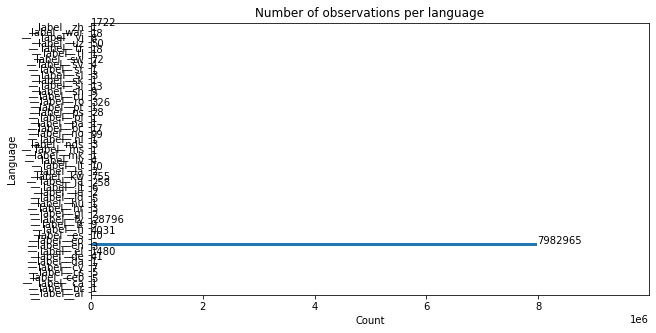

In [22]:
vc = df_yelp.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [23]:
vc.nlargest(5)

__label__en    7982965
__label__fr      28796
__label__es       4031
__label__zh       1722
__label__de       1480
Name: lang, dtype: int64

In [25]:
f"{vc['__label__en']/df_yelp.shape[0]*100:.4f}% of samples are english" 

'99.5243% of samples are english'